## Import data

In [29]:
import pandas as pd # pyright: ignore[reportMissingModuleSource]

df = pd.read_csv("data3.csv", sep=";")
print(df.shape)  # dimensions
print(df.info())  # types and missing values
print(df.head())  # 5 first lines

emg_cols = ['EMG1', 'EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7', 'EMG8']

(9369, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9369 entries, 0 to 9368
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Email       9369 non-null   object
 1   EMG1        9369 non-null   int64 
 2   EMG2        9369 non-null   int64 
 3   EMG3        9369 non-null   int64 
 4   EMG4        9369 non-null   int64 
 5   EMG5        9369 non-null   int64 
 6   EMG6        9369 non-null   int64 
 7   EMG7        9369 non-null   int64 
 8   EMG8        9369 non-null   int64 
 9   Framecount  9369 non-null   int64 
 10  gesture     9369 non-null   object
 11  SessionID   9369 non-null   object
 12  Timestamp   9369 non-null   object
dtypes: int64(9), object(4)
memory usage: 951.7+ KB
None
       Email  EMG1  EMG2  EMG3  EMG4  EMG5  EMG6  EMG7  EMG8  Framecount  \
0  anonymous   -22   -11   -25   -59    44    29   -39    -2           2   
1  anonymous     5     8    18   104    21    40    92     8           2 

## Clean data
### Manage missing data

In [30]:
df = df.drop_duplicates()  # remove duplicate rows


# remove rows with missing values
df = df.dropna()

# Or fill missing numeric values with column mean
for col in emg_cols:
    df[col] = df[col].fillna(df[col].mean())


### Prepare data

In [31]:
from sklearn.preprocessing import LabelEncoder, StandardScaler # pyright: ignore[reportMissingModuleSource]


# # Detect outliers using Inter Quartile Range (IQR)
# for col in emg_cols:
#     Q1 = df[col].quantile(0.25)
#     Q3 = df[col].quantile(0.75)
#     IQR = Q3 - Q1

#     df = df[~((df[col] < (Q1 - 4 * IQR)) | (df[col] > (Q3 + 4 * IQR)))]

# Standardization
scaler = StandardScaler()
df[emg_cols] = scaler.fit_transform(df[emg_cols])

print("Standardized EMG columns:")
print(df[emg_cols].head())

# Label Encoding
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['gesture'])
print("\nEncoded labels:")
print(df[['label', 'gesture']].drop_duplicates())

Standardized EMG columns:
       EMG1      EMG2      EMG3      EMG4      EMG5      EMG6      EMG7  \
0 -1.299412 -1.966123 -1.158052 -2.125787  1.826743  1.150224 -2.041328   
1  0.361418  1.731505  0.921554  3.902242  0.891646  1.575626  4.831373   
2  0.176881 -1.187675 -1.496593 -3.272221 -0.409358 -1.634228  4.254276   
3 -0.561265 -2.549959  0.583014  2.238062 -1.994957 -0.938115 -3.457839   
4 -0.376729 -0.409227 -2.608940 -1.755969  1.176240  1.614299 -4.402180   

       EMG8  
0 -0.065730  
1  0.515618  
2 -0.705213  
3 -0.356404  
4  0.108675  

Encoded labels:
      label gesture
0         2    open
1804      0   close
4017      3     pin
6927      1    down


### Split data

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Use the cleaned and prepared dataframe from previous cells
# Separate features (X) and labels (y)
X = df[emg_cols]
y = df['label']

# 3. Split dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Baseline model
### Search best hyperparameter

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define model
search_model = DecisionTreeClassifier(random_state=42)

# Define parameter grid
param_grid = {
    "max_depth": [2, 4, 6, 8, 10, None],
    "criterion": ["gini", "entropy"]
}

# Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(search_model, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best validation accuracy:", grid_search.best_score_)


Best parameters: {'criterion': 'gini', 'max_depth': None}
Best validation accuracy: 0.6976214396011237


### Train model

In [34]:
# 4. Train a simple Decision Tree
model = DecisionTreeClassifier(random_state=42, criterion=grid_search.best_params_["criterion"], max_depth=grid_search.best_params_["max_depth"])
model.fit(X_train, y_train)


,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


## Evaluation

Validation accuracy: 0.701779359430605
              precision    recall  f1-score   support

           0       0.60      0.55      0.57       336
           1       0.92      0.93      0.92       374
           2       0.72      0.68      0.70       275
           3       0.58      0.64      0.61       420

    accuracy                           0.70      1405
   macro avg       0.70      0.70      0.70      1405
weighted avg       0.70      0.70      0.70      1405

Cross-validation scores: [0.60142349 0.69395018 0.65480427 0.6405694  0.72241993]
Mean accuracy: 0.6626334519572954


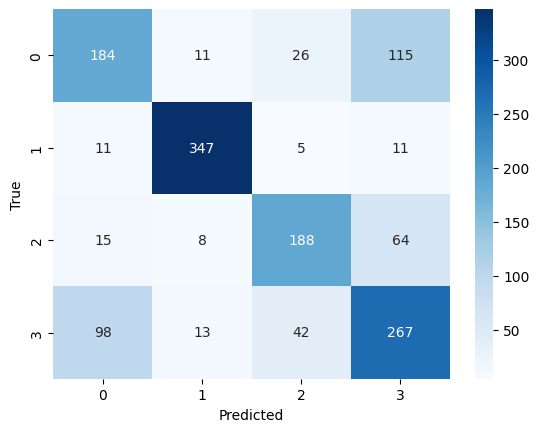

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


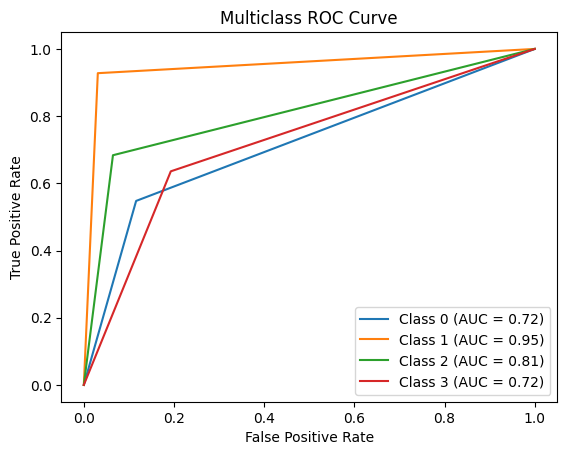

In [35]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_val, y_val):
    # Evaluate on validation set
    y_pred = model.predict(X_val)
    print("Validation accuracy:", accuracy_score(y_val, y_pred))
    print(classification_report(y_val, y_pred))
	
    # Cross-validation
    scores = cross_val_score(model, X_val, y_val, cv=5)
    print("Cross-validation scores:", scores)
    print("Mean accuracy:", scores.mean())


    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_pred)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


    # Predict probabilities for the first 5 samples in the validation set
    probs = model.predict_proba(X_val[:5])
    print(probs)


    # ROC Curve
    y_val_bin = label_binarize(y_val, classes=model.classes_)
    probs_full = model.predict_proba(X_val)

    plt.figure()
    for i in range(y_val_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_val_bin[:, i], probs_full[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve")
    plt.legend()
    plt.show()

evaluate_model(model, X_val, y_val)


## Artificial Neural Network

Training improved neural network...
Training completed!
Number of iterations: 155
Final loss: 0.3614

=== IMPROVED NEURAL NETWORK RESULTS ===
Validation accuracy: 0.80355871886121
              precision    recall  f1-score   support

           0       0.69      0.77      0.73       336
           1       0.97      0.96      0.96       374
           2       0.85      0.78      0.81       275
           3       0.72      0.71      0.72       420

    accuracy                           0.80      1405
   macro avg       0.81      0.80      0.81      1405
weighted avg       0.81      0.80      0.80      1405

Cross-validation scores: [0.77224199 0.78647687 0.75800712 0.70818505 0.76512456]
Mean accuracy: 0.7580071174377225


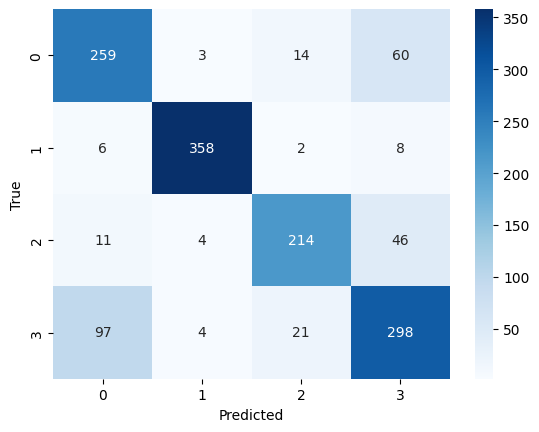

[[2.95189717e-01 1.05067523e-05 6.52433682e-01 5.23660943e-02]
 [2.97188690e-08 9.99999821e-01 1.48627905e-07 5.14889203e-10]
 [2.92429221e-01 5.05603083e-07 7.02712010e-01 4.85826381e-03]
 [8.75769732e-11 9.99999990e-01 6.72036582e-09 2.85563995e-09]
 [1.43849884e-02 5.85404671e-08 9.52387173e-01 3.32277805e-02]]


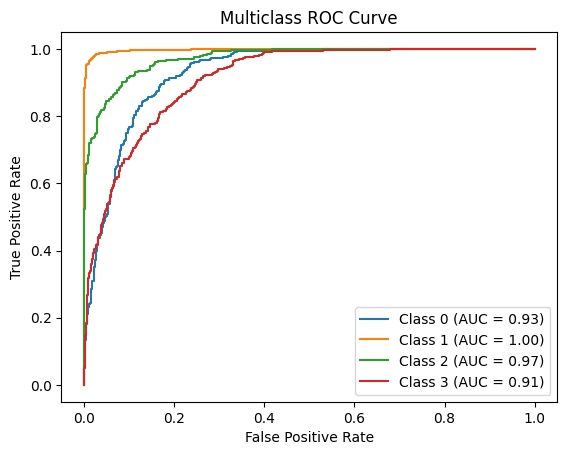

In [36]:
from sklearn.neural_network import MLPClassifier

def create_mlp_model(hidden_layer_sizes, activation, alpha, learning_rate_init):
    return MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver='adam',
        alpha=alpha,                                    # L2 regularization
        learning_rate_init=learning_rate_init,
        max_iter=2000,
        validation_fraction=0.2,                        # Use 20% of training data for validation
        early_stopping=True,                            # Stop when validation score stops improving
        n_iter_no_change=50,                            # Stop after 50 iterations without improvement
        random_state=42,
        batch_size='auto'
    )

mlp = create_mlp_model(
    hidden_layer_sizes=(32, 16),
    activation='relu',
    alpha=0.001,
    learning_rate_init=0.001,
)

print("Training improved neural network...")
mlp.fit(X_train, y_train)

print("Training completed!")
print(f"Number of iterations: {mlp.n_iter_}")
print(f"Final loss: {mlp.loss_:.4f}")

# Evaluate the improved model
print("\n=== IMPROVED NEURAL NETWORK RESULTS ===")
evaluate_model(mlp, X_val, y_val)

## Hyperparameter optimization

[I 2025-08-19 14:06:58,527] A new study created in memory with name: no-name-7c741210-5cff-4889-b34e-3970922f5937
[I 2025-08-19 14:07:00,810] Trial 0 finished with value: 0.8104605062519061 and parameters: {'hidden_layer_sizes': '64', 'activation': 'tanh', 'alpha': 0.02717960021212083, 'learning_rate_init': 0.018710345872445234}. Best is trial 0 with value: 0.8104605062519061.
[I 2025-08-19 14:07:02,021] Trial 1 finished with value: 0.8089356511131442 and parameters: {'hidden_layer_sizes': '32', 'activation': 'relu', 'alpha': 0.00988648558796756, 'learning_rate_init': 0.019573500095126612}. Best is trial 0 with value: 0.8104605062519061.
[I 2025-08-19 14:07:12,370] Trial 2 finished with value: 0.8023787740164684 and parameters: {'hidden_layer_sizes': '64', 'activation': 'tanh', 'alpha': 0.00021037429639172143, 'learning_rate_init': 0.000835741842771731}. Best is trial 0 with value: 0.8104605062519061.
[I 2025-08-19 14:07:17,562] Trial 3 finished with value: 0.7830131137541932 and param

Top 5 trials:
        value params_hidden_layer_sizes params_activation  params_alpha  \
8   0.811070                        64              relu      0.000291   
0   0.810461                        64              tanh      0.027180   
1   0.808936                        32              relu      0.009886   
12  0.804666                        64              tanh      0.000125   
5   0.804056                     64-32              tanh      0.002955   

    params_learning_rate_init  
8                    0.006756  
0                    0.018710  
1                    0.019574  
12                   0.008458  
5                    0.002448  


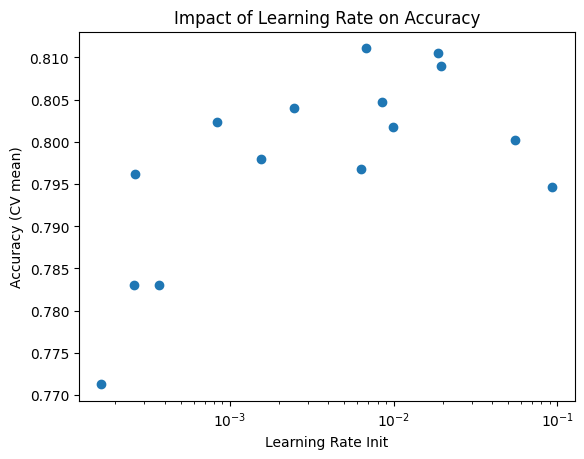

In [38]:
import optuna

def objective(trial):
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', ['32', '64', '64-32', '128-64'])
    layer_map = {
        '32': (32,),
        '64': (64,),
        '64-32': (64, 32),
        '128-64': (128, 64)
    }
    hidden_layer_sizes = layer_map[hidden_layer_sizes]

    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    alpha = trial.suggest_float('alpha', 1e-4, 1e-1, log=True)
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-4, 1e-1, log=True)

    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        max_iter=2000,
        early_stopping=True,
        random_state=42
    )

    scores = cross_val_score(mlp, X_train, y_train, cv=3, scoring='accuracy')
    return scores.mean()

# Run optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

# -------------------------------
# 📊 Step 12.1 - Results Analysis
# -------------------------------
# Convert trials to a DataFrame
df_results = study.trials_dataframe()

# Sort by best accuracy
df_sorted = df_results.sort_values('value', ascending=False)
print("Top 5 trials:\n", df_sorted[['value', 'params_hidden_layer_sizes', 
                                    'params_activation', 'params_alpha', 
                                    'params_learning_rate_init']].head())

# -------------------------------
# 📈 Step 12.2 - Visualization
# -------------------------------
# Plot accuracy vs learning rate
plt.scatter(df_results['params_learning_rate_init'], df_results['value'])
plt.xscale('log')
plt.xlabel("Learning Rate Init")
plt.ylabel("Accuracy (CV mean)")
plt.title("Impact of Learning Rate on Accuracy")
plt.show()


Best parameters: {'hidden_layer_sizes': '64', 'activation': 'relu', 'alpha': 0.0002905741277710972, 'learning_rate_init': 0.006755906989347593}
Training improved neural network...
Training completed!
Number of iterations: 151
Final loss: 0.3368

=== IMPROVED NEURAL NETWORK RESULTS ===
Validation accuracy: 0.8156583629893238
              precision    recall  f1-score   support

           0       0.70      0.79      0.74       336
           1       0.98      0.98      0.98       374
           2       0.89      0.79      0.84       275
           3       0.73      0.71      0.72       420

    accuracy                           0.82      1405
   macro avg       0.82      0.82      0.82      1405
weighted avg       0.82      0.82      0.82      1405

Cross-validation scores: [0.78647687 0.80427046 0.72597865 0.72953737 0.80782918]
Mean accuracy: 0.7708185053380783


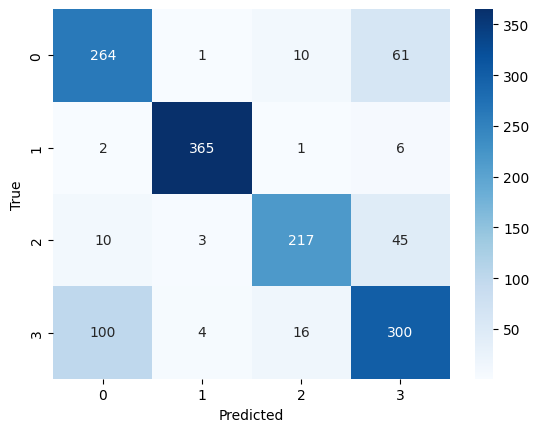

[[6.97470366e-01 4.50323172e-11 2.90130636e-01 1.23989976e-02]
 [3.19485284e-14 1.00000000e+00 2.06619340e-11 1.24104084e-14]
 [2.70250912e-01 4.07381772e-17 7.29719494e-01 2.95941591e-05]
 [3.90472966e-15 1.00000000e+00 5.07018052e-12 5.10669145e-11]
 [5.91690735e-02 3.78034745e-14 9.32573413e-01 8.25751363e-03]]


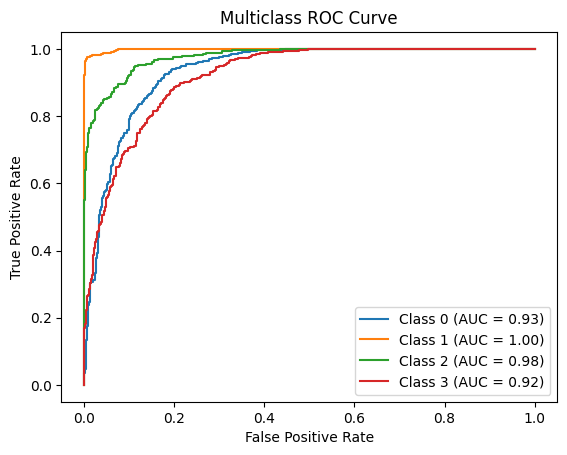


============== Test Accuracy: 0.817923186344239 ==============
              precision    recall  f1-score   support

           0       0.68      0.81      0.74       300
           1       0.98      0.95      0.97       379
           2       0.87      0.80      0.83       296
           3       0.76      0.72      0.74       431

    accuracy                           0.82      1406
   macro avg       0.82      0.82      0.82      1406
weighted avg       0.82      0.82      0.82      1406



In [ ]:
# Train the best model on full training set
best_params = study.best_trial.params
print("Best parameters:", best_params)

layers = [int(x) for x in best_params['hidden_layer_sizes'].split('-')]
best_mlp = create_mlp_model(
    hidden_layer_sizes=layers,
    activation=best_params['activation'],
    alpha=best_params['alpha'],
    learning_rate_init=best_params['learning_rate_init'],
)

print("Training improved neural network...")
best_mlp.fit(X_train, y_train)

print("Training completed!")
print(f"Number of iterations: {best_mlp.n_iter_}")
print(f"Final loss: {best_mlp.loss_:.4f}")

# Evaluate the improved model
print("\n=== IMPROVED NEURAL NETWORK RESULTS ===")
evaluate_model(best_mlp, X_val, y_val)

# Evaluate on test set
y_pred = best_mlp.predict(X_test)
print("\n============== Test Accuracy:", accuracy_score(y_test, y_pred), "==============")
print(classification_report(y_test, y_pred))


### Model export

In [ ]:
# train_export.py
import json
import os
import joblib
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from datetime import datetime

FEATURE_NAMES = [f"f{i}" for i in range(1, 9)]  # exactly 8 inputs in fixed order
CLASS_NAMES = ["fist", "wrist_back", "wrist_forward", "pinch"]  # example labels

# X, y are your prepared arrays
# X.shape == (n_samples, 8), y in {0..3}
# ...

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", create_mlp_model(
        hidden_layer_sizes=layers,
        activation=best_params['activation'],
        alpha=best_params['alpha'],
        learning_rate_init=best_params['learning_rate_init'],
    ))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)

metrics = {
    "accuracy": float(accuracy_score(y_val, y_pred)),
    "report": classification_report(y_val, y_pred, target_names=CLASS_NAMES, output_dict=True),
}

timestamp = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
model_dir = f"models/gesture_cls/1.0.0_{timestamp}"
os.makedirs(model_dir, exist_ok=True)

# 1) Save pipeline
joblib.dump(pipe, f"{model_dir}/pipeline.joblib")

# 2) Save config (schema, classes, thresholds, etc.)
config = {
    "feature_names": FEATURE_NAMES,
    "class_names": CLASS_NAMES,
    "top_k": 2,
    "abstain_threshold": 0.6,  # below this max prob => "unknown"
    "random_state": 42,
    "library": {"sklearn": ">=1.2"},
}
with open(f"{model_dir}/config.json", "w") as f:
    json.dump(config, f, indent=2)

# 3) Save metrics
with open(f"{model_dir}/metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Model exported to:", model_dir)


Model exported to: models/gesture_cls/1.0.0_20250819T122027Z
